# Assignment 1 (100 pts, BONUS: 10 pts) - Knowledge about Language (syntax, lexical semantic, morphology), Scraping, Text Processing, LM, Analysis
---

In this assignment, you will learn about linguistic knowledge (syntax, lexical semantic, morphology), scraping, pre-processing, and conducting preliminary analysis of text, which are very important when doing NLP, and use python libraries such as NLTK, spacy, which are popular in NLP.

## Problem 1. (5 pts)
---

In online discussion forums, such as Reddit, discussions are broken down into different communities. Given such forum and using your knowledge of language modeling so far:

### 1. (2.5 pts) For a given post, how do use language model to determine which community it likely belongs to?

-> answer

### 2. (2.5 pts) How do you automatically generate posts that will fit a particular community using language modeling?

-> answer

## Problem 2. (20 pts)
---

In this problem, you will learn to think like a computer and understand and translate a language that is unknown to you (Tshiluba) to/from a language that is known to you (English). To help you along, here are some sentences in Tshiluba and their corresponding English sentences. You must derive knowledge of the language such as morphology and lexical semantics from these examples to help you answer the following questions (we humans are very good at this and do not need thousands of sentences to derive this knowledge).

    mukaji uvwa mumona muana → the woman saw the child.
    bakaji bavwa bamona muana → the women saw the child. 
    muluma uvwa mumona bakaji → the man saw the women. 
    muluma uvwa mumona bambuji → the man saw the goats. 
    muluma udi mumona bambuji → the man sees the goats.
    banzolu bavwa bamona bantambwe → the chickens saw the lions. 
    tubambwa tuvwa tumona baluma → the small dogs saw the men. 
    mbwa uvwa mumona ntambwe → the dog saw the lion.
    ntambwe uvwa mumona tubanzolu → the lion saw the small chickens.
    kanzolu kavwa kamona tubantambwe → the small chicken saw the small lions. 
    tubakulu tuvwa tumona mbwa → the small adults saw the dog.
    kamuntu kavwa kapeta ntambwe → the small person found the lion. 
    kamulunda kavwa kapeta ntambwe → the small friend found the lion. 
    fruit → cimuma.
    fruits → bimuma.


### 1. Translate the following into Tshiluba:

(a) (2 pts) The men found the children

-> answer

(b) (2 pts) The chicken saw the dogs

-> answer

(c) (2 pts) The small chickens found the goat

-> answer

(d) (2 pts) The small child found the small goat

-> answer

(e) (2 pts) The friend found the goat

-> answer

### 2. Translate the following into English:

(a) (2 pts) bantu

-> answer

(b) (2 pts) kamukulu

-> answer

(c) (2 pts) tubalunda

-> answer

(d) (2 pts) cimuma civwa cimona kantambwe

-> answer

(e) (2 pts) kantambwe kavwa kamona tubimuma

-> answer

## Problem 3. (25 pts, bonus: 10 pts) Twitter Scraping and pre-processing using NLTK.
---

Use your Twitter Developer API to scrape 10,000 most <ins>recent</ins> tweets in the English language from Twitter with the keyword ’nft’. Additionally scrape 1000 tweets using the keyword ’football’. Save your tweets in <ins>two files</ins> with respective names for submission. You can use the search function of library such as **Twython**.

Out of the 10,000 nft tweets, use 9,000 to train a unigram, bigram, and trigram language models (LMs). Use **NLTK** library with <ins>KneserNeyInterpolated</ins> language model (currently possibly the best for smoothing) to build your LMs. This particular language model can deal with zero-count ngrams(out of vocabulary ngrams).

Pre-process the text first before using it to train your LMs. The pre-processing steps that you must do are:

* Sentence segment/split
* Tokenize (you should use TweetTokenizer from NLTK.tokenize)
* Lower case
* Padding with begin-of-sentence and end-of-sentence symbols (check out steps how to do this and train NLTK LM at this [link](https://www.kaggle.com/alvations/n-gram-language-model-with-nltk))

All of these can be done within NLTK. **Don’t forget** to do the <ins>same</ins> pre-processing on your <ins>test</ins> examples before processing them with the LM.

In [1]:
%%capture
import tweepy
import os.path as path
import json
from keys import CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET
import re
import string
import spacy
import nltk # v3.6.1
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.lm.models import KneserNeyInterpolated
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from collections import Counter, defaultdict
import requests
from bs4 import BeautifulSoup
from newspaper import Article
from wordcloud import WordCloud
import matplotlib.pyplot as plt

!python3 -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('wordnet')

In [2]:
def getTweets(topic, count=10000):
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
    api = tweepy.API(auth, wait_on_rate_limit=True)

    filename = topic + '_tweets.json'
    if not path.exists(filename):
        tweets_all = []
        for _ in range(count // 100):
            tweets_all.append(
                api.search_tweets(q=topic,
                                  result_type='recent',
                                  count=100,
                                  lang='en',
                                  tweet_mode="extended"))

        with open(filename, 'w') as fout:
            for tweets_100 in tweets_all:
                for tweet in tweets_100:
                    json.dump(tweet._json, fout)
                    fout.write('\n')

    tweets = []
    with open(filename) as f:
        for line in f:
            tweets.append(json.loads(line))

    tweet_content = []
    for tweet in tweets:
        if 'retweeted_status' in tweet.keys():
            content = tweet['retweeted_status']['full_text']
        else:
            content = tweet['full_text']
        tweet_content.append(content)

    return tweets, tweet_content


In [3]:
nft, nft_tweets = getTweets('nft')
football, football_tweets = getTweets('football', 1000)

In [4]:
def cleanTweet(tweet):
    # Remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)

    # Remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)

    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)

    # Remove hashtags
    tweet = re.sub(r'#', '', tweet)

    # Remove emojis
    tweet = tweet.encode('ascii', 'ignore').decode('ascii')

    return tweet


def processTweet(tweet):
    tweet = cleanTweet(tweet)

    tokens = []
    for sentence in nltk.sent_tokenize(tweet):
        tweet_tokens = TweetTokenizer(preserve_case=False,
                                      strip_handles=True,
                                      reduce_len=True).tokenize(sentence)
        if len(tweet_tokens) > 0:
            tokens.append(tweet_tokens)

    return tokens

In [5]:
nft_train, nft_test, football_test = [], [], []
for text in nft_tweets[:9000]:
    nft_train.extend(processTweet(text))

for text in nft_tweets[9000:]:
    nft_test.extend(processTweet(text))

for text in football_tweets:
    football_test.extend(processTweet(text))

print('Number of training sentences:', len(nft_train))
print('Number of test sentences:', len(nft_test))

Number of training sentences: 17540
Number of test sentences: 1955


### 1. (5 pts) Report the <ins>average</ins> perplexities of your language models on the remaining 1,000 tweets with the keyword ’nft’ i.e., use NLTK LM perplexity function to compute the perplexity of each tweet, and then average.

In [6]:
def trainLM(N_GRAM, X):
    data, padded_sents = padded_everygram_pipeline(N_GRAM, X)

    model = KneserNeyInterpolated(N_GRAM)
    model.fit(data, padded_sents)

    return model

In [7]:
UNI_GRAM, BI_GRAM, TRI_GRAM = 1, 2, 3

uni_model = trainLM(UNI_GRAM, nft_train)
bi_model = trainLM(BI_GRAM, nft_train)
tri_model = trainLM(TRI_GRAM, nft_train)

In [8]:
def testLM(model, N_GRAM, X):
    data, _ = padded_everygram_pipeline(N_GRAM, X)

    perplex = []
    for d in data:
        ngram_sent = []
        for ngram in list(d):
            if len(ngram) == N_GRAM:
                ngram_sent.append(ngram)

        perplex.append(model.perplexity(ngram_sent))

    return np.mean(perplex)

In [9]:
uni_perplex = testLM(uni_model, UNI_GRAM, nft_test)
bi_perplex = testLM(bi_model, BI_GRAM, nft_test)
tri_perplex = testLM(tri_model, TRI_GRAM, nft_test)

print('Unigram perplexity:', uni_perplex)
print('Bigram perplexity:', bi_perplex)
print('Trigram perplexity:', tri_perplex)

Unigram perplexity: 3963.0
Bigram perplexity: 2838.3411037814562
Trigram perplexity: 3415.0321439998133


### 2. (4 pts) Report the <ins>average</ins> perplexities of your language models on the test set that you scraped using the keyword ’football’. How are the perplexities changed?

In [10]:
uni_perplex = testLM(uni_model, UNI_GRAM, football_test)
bi_perplex = testLM(bi_model, BI_GRAM, football_test)
tri_perplex = testLM(tri_model, TRI_GRAM, football_test)

print('Unigram perplexity:', uni_perplex)
print('Bigram perplexity:', bi_perplex)
print('Trigram perplexity:', tri_perplex)

Unigram perplexity: 3963.000000000003
Bigram perplexity: 26407.20473528922
Trigram perplexity: 20915.49945182356


### 3. (6 pts) Generate 10 tweets using each of your language models (unigram, bigram and trigram models) (for a total of 30 tweets).

In [11]:
def generate_sentences(model, num_words=20):
    content = []
    for token in model.generate(num_words):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return TreebankWordDetokenizer().detokenize(content)

In [12]:
unigram_tweets, bigram_tweets, trigram_tweets = [], [], []

for _ in range(10):
    unigram_tweets.append(generate_sentences(uni_model))
    bigram_tweets.append(generate_sentences(bi_model))
    trigram_tweets.append(generate_sentences(tri_model))

In [13]:
with open('generated_tweets.txt', 'w') as f:
    for tweets in unigram_tweets + bigram_tweets + trigram_tweets:
        f.write("{}\n".format(tweets))

print('Unigram Tweets:\n', unigram_tweets[:3], '\n')
print('Bigram Tweets:\n', bigram_tweets[:3], '\n')
print('Trigram Tweets:\n', trigram_tweets[:3], '\n')

Unigram Tweets:
 ['cause 7557 japan end-to-end beachcleanup love solananftproject izumi handled tonight crew utilities snippet patient gradually transform charts cents 6 tuesday', 'shapes female nftairdrop exclusive okja ml dapps xdc assign pic x3 besides launched apenft do combined derage eligible 20k nftprojects', 'bbigsqueeze explain competition does available 1oz fight transfer utility practical protocol cofko freebtc notifi bscgemalert weds europe collaborated originalsong repeat'] 

Bigram Tweets:
 ['rides on - join doscord - 11 winners picked in 24 hours sol adagiveaway 15!) this space.', 'render 3dmodel nft space out the game and - follow & rt, 2022 5 wl 2x 2x wl giveaway', 'investin'] 

Trigram Tweets:
 ['blessed day like i feel the pains cause i have finally secured 2 x wl spots to enter: follow', "aren't a meta.", 'website'] 



### 4. (10 pts, Bonus: 10 pts) Using NLTK library (with VADER, which is a lexicon and rule-based sentiment analysis model, see this [link](https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/) for example usage), compute the sentiment of each tweet in all your <ins>10,000</ins> tweets.

(a) (4 pts) What is the average **compound** sentiment of the tweets from VADER? Are users in your collected tweets generally positive/neutral/negative when talking about NFTs?

In [14]:
sent_analyser = SentimentIntensityAnalyzer()
compound_score = []
postive, neutral, negative = 0, 0, 0
pos_tweets, neutral_tweets, neg_tweets = [], [], []

for text in nft_tweets:
    sentiment = sent_analyser.polarity_scores(text)
    score = sentiment['compound']
    compound_score.append(score)

    if score >= 0.05:
        postive += 1
        pos_tweets.append(text)
    elif score < 0.05 and score > -0.05:
        neutral += 1
        neutral_tweets.append(text)
    elif score <= -0.05:
        negative += 1
        neg_tweets.append(text)

print('Average compound score:', round(np.mean(compound_score), 3))
print("Positive: {},  Neutral: {},  Negative: {}".format(
    postive, neutral, negative))

Average compound score: 0.526
Positive: 7892,  Neutral: 1510,  Negative: 590


(b) (6 pts) For positive tweets, what are the top 10 <ins>non</ins> stop words mentioned? Similarly, for negative tweets, what are the top 10 <ins>non</ins> stop words mentioned? (See this [link](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/) for an example of removing stop words from a list using NLTK)

In [15]:
def removeStopWords(tweet):
    tweet = cleanTweet(tweet)

    lemmatiser = WordNetLemmatizer()
    stopwords_english = nlp.Defaults.stop_words
    tokeniser = TweetTokenizer(preserve_case=False,
                               strip_handles=True,
                               reduce_len=True)

    clean = []
    for word in tokeniser.tokenize(tweet):
        if word not in stopwords_english and word not in string.punctuation and len(
                word) > 1 and re.search('[a-zA-Z]', word):
            clean.append(lemmatiser.lemmatize(word))

    return clean

In [16]:
pos_words = []
for tweet in pos_tweets:
    pos_words.extend(removeStopWords(tweet))

pos_counts = Counter(pos_words)

print('Top 10 positive non stop words:')
pos_counts.most_common(10)

Top 10 positive non stop words:


[('nft', 7618),
 ('giveaway', 4477),
 ('follow', 4065),
 ('wl', 3864),
 ('rt', 3575),
 ('friend', 3507),
 ('tag', 3464),
 ('like', 3373),
 ('spot', 2917),
 ('enter', 2823)]

In [17]:
neg_words = []
for tweet in neg_tweets:
    neg_words.extend(removeStopWords(tweet))

neg_counts = Counter(neg_words)

print('Top 10 negative non stop words:')
neg_counts.most_common(10)

Top 10 negative non stop words:


[('nft', 617),
 ('discord', 216),
 ('giveaway', 204),
 ('follow', 156),
 ('rt', 144),
 ('nftcommunity', 140),
 ('nftdrop', 138),
 ('join', 138),
 ('cyberpunk', 126),
 ('nfts', 126)]

(c) (Bonus 10 pts) Using only tweets that are geo-located with **country_code** US i.e., has non-null child object **place** in its json, extract the state information from the **full_name** child object of place. Report average sentiment compound scores from each of the state you found. Which state in your data has the most positive users, which state has the most negative users?

In [18]:
tweets_within_US = []
for tweet in nft:
    if tweet['place'] != None and tweet['place']['country_code'] == 'US':
        info = {'state': tweet['place']['full_name'].split(', ')[-1]}

        if 'retweeted_status' in tweet.keys():
            info['text'] = cleanTweet(tweet['retweeted_status']['full_text'])
        else:
            info['text'] = cleanTweet(tweet['full_text'])

        tweets_within_US.append(info)

print('Number of tweets located in the US:', len(tweets_within_US))

Number of tweets located in the US: 19


In [19]:
state_score = defaultdict(list)

for info in tweets_within_US:
    text, state = info['text'], info['state']

    score = sent_analyser.polarity_scores(text)['compound']
    state_score[state].append(score)

scores = {}
for key, values in state_score.items():
    scores[key] = round(np.mean(values), 3)

scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)


In [20]:
print('Most positive US state:', scores[0])
print('Most negative US state:', scores[-1])

Most positive US state: ('TX', 0.581)
Most negative US state: ('CA', 0.0)


## Problem 4. (30 pts) Wikipedia Scraping and pre-processing using Spacy.
---

Use library such as **requests** to scrape HTML of this article in Wikipedia:

    https://en.wikipedia.org/wiki/Non-fungible_token

Then, scrape the URLs of all <ins>articles within Wikipedia</ins> that are linked from only the **content** of this page i.e., you don’t need to scrape the sidebar—you will have to look at the retrieved HTML of the first page and see the pattern you can use to obtain links from this article’s <ins>content</ins> to other Wikipedia <ins>articles</ins>.

See this [link](https://en.wikipedia.org/wiki/Wikipedia:What_is_an_article%3F) for what is defined as an <ins>article</ins> in Wikipedia.

Once you retrieve the links to all the articles (including the original article `https://en.wikipedia.org/wiki/Non-fungible_token`), using library such as **BeautifulSoup** or regular expressions of your creation, extract only the text of each article’s <ins>content</ins>. Save your Wikipedia texts in a <ins>single text file</ins> (one line per Wikipedia article).

In [21]:
def getWikiData():
    if not path.exists('wiki_data.txt'):
        wiki_url = 'https://en.wikipedia.org/wiki/Non-fungible_token'
        result = requests.get(wiki_url)
        first_page = result.text

        soup = BeautifulSoup(first_page, 'html.parser')
        first_page_content = soup.find(id='mw-content-text')
        urlList = first_page_content.findAll('a', href=re.compile('^/wiki/'))

        urlList_clean = []
        for link in urlList[:]:
            if not re.search(
                    'Help:|File:|Wikipedia:|Portal:|Template:|Category:|Template_talk|Special|Book:',
                    link.get('href')):
                urlList_clean.append('https://en.wikipedia.org' +
                                     link.get('href'))
        urlList_clean = list(set(urlList_clean))
        urlList_clean.insert(0, wiki_url)

        wiki_content = []
        for url in urlList_clean:
            r = requests.get(url)
            html_doc = r.text
            soup = BeautifulSoup(html_doc, 'html.parser')
            para = soup.find_all('p')
            article = []
            for p in para:
                if (p.has_attr('class') and ('mw-empty-elt' in p['class'])):
                    continue
                article.append(p.get_text())
            wiki_content.append(article)

        with open('wiki_data.txt', 'w') as fout:
            for article in wiki_content:
                for content in article:
                    fout.write(content)

    wiki_text = []
    with open('wiki_data.txt') as f:
        for line in f:
            line = line.replace('\xa0', ' ').replace('\ufeff', ' ')
            wiki_text.append(line.strip())

    return wiki_text

In [22]:
wiki_text = getWikiData()

### 1. (10 pts) Sentence split, tokenize, lemmatize, lower case the text using the library **Spacy**. Then, construct a vocabulary of words in the text.

In [23]:
def process_wiki_data(text):
    lemmatiser = WordNetLemmatizer()
    stopwords_english = nlp.Defaults.stop_words

    text = re.sub(r'\[\d*\]', ' ', text)
    text = re.sub(r'‡', '', text)
    sentences = nltk.sent_tokenize(text)

    data = []
    for sentence in sentences:
        text_tokens = nltk.word_tokenize(sentence)
        text_clean = []
        for word in text_tokens:
            word = word.lower()
            if word not in stopwords_english and word not in string.punctuation and len(
                    word) > 1 and re.search('[a-zA-Z]', word):
                lem_word = lemmatiser.lemmatize(word)
                text_clean.append(lem_word)

        if len(text_clean) > 0:
            data.append(text_clean)

    return data

In [24]:
wiki_sentences = []
for text in wiki_text:
    sents = process_wiki_data(text)
    wiki_sentences.extend(sents)

wiki_words = []
for sent in wiki_sentences:
    wiki_words.extend(sent)
print('Number of wiki words:', len(wiki_words))

Number of wiki words: 359407


(a) (5 pts) What are the top 20 <ins>non</ins> stop words in the vocabulary according to frequency (use **Spacy** to remove stop words like shown in this [link](https://stackabuse.com/removing-stop-words-from-strings-in-python/))? Are they from a specific topic? Do they give you insights into what the text is all about?

In [25]:
wiki_vocab = Counter(wiki_words)
print('Wiki vocab size:', len(wiki_vocab))
wiki_vocab.most_common(20)

Wiki vocab size: 32213


[('game', 1839),
 ('film', 1458),
 ('new', 1415),
 ('art', 1243),
 ('company', 1237),
 ('user', 1186),
 ('use', 1182),
 ('bitcoin', 1143),
 ('digital', 1122),
 ('time', 1095),
 ('million', 985),
 ('system', 974),
 ('work', 973),
 ('cryptocurrency', 865),
 ('year', 819),
 ('state', 817),
 ('network', 770),
 ('blockchain', 766),
 ('video', 756),
 ('computer', 749)]

(b) (5 pts) Using library such as **wordcloud**, generate the word cloud of the text to visualize the distribution of <ins>non</ins> stop words. Does the word cloud give you some insights into what the text is all about?

In [26]:
def createWordcloud(text, filename):
    wordcloud = WordCloud(background_color="white", margin=2).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    wordcloud.to_file(filename)

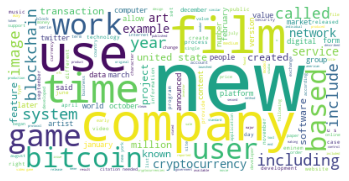

In [27]:
createWordcloud(' '.join(wiki_words), 'wikipedia_wordcloud.png')

### 2. (10 pts) Use **Spacy** again to sentence split, tokenize, lemmatize, lower case the 1,000 <ins>non-preprocessed</ins> test tweets with keyword ’nft’ you’ve collected in **Problem 3**.

In [28]:
nft_test_words = []
for tweet in nft_tweets[:9000]:
    nft_test_words.extend(removeStopWords(tweet))

In [29]:
nft_test_vocab = Counter(nft_test_words)

(a) (2 pts) Compute how many <ins>word types</ins> in your tweets are out-of-vocabulary, normalized by the number of word types in your tweets, when using vocabulary constructed from Wikipedia texts above.

In [30]:
type = 0
for word in nft_test_vocab:
    if word not in wiki_vocab:
        type += 1

print('Word type OOV-rate:', type / len(nft_test_vocab))

Word type OOV-rate: 0.3990922844175492


(b) (2 pts) Compute how many <ins>word tokens</ins> in your tweets are out of vocabulary, normalized by the number of word tokens in your tweets. This is the OOV-rate of your tweet test set.

In [31]:
tokens = 0
for word in nft_test_words:
    if word not in wiki_vocab:
        tokens += 1

print('Word token OOV-rate:', tokens / len(nft_test_words))

Word token OOV-rate: 0.2822577794118687


(c) (4 pts) Compute the OOV-rate of your tweet test set when using your 9,000 train tweets from **Problem 3** to construct your vocabulary/lexicon. Note that you have to do the same pre-processing on your <ins>non-processed</ins> tweet train set (i.e., sentence split, tokenize, lemmatize, lower case using **Spacy**) before constructing the vocabulary.

In [32]:
nft_train_words = []
for tweet in nft_tweets[9000:]:
    nft_train_words.extend(removeStopWords(tweet))

nft_train_vocab = Counter(nft_train_words)

type = 0
for word in nft_train_vocab:
    if word not in wiki_vocab:
        type += 1

print('Word type OOV-rate:', type / len(nft_train_vocab))

tokens = 0
for word in nft_train_words:
    if word not in wiki_vocab:
        tokens += 1

print('Word token OOV-rate:', tokens / len(nft_train_words))

Word type OOV-rate: 0.3372681281618887
Word token OOV-rate: 0.2924569367576643


(d) (2 pts) What does the OOV-rate tell you about the domain of these two texts (Wikipedia vs. Twitter of similar topic that is NFT)?

-> answer

### 3. (10 pts) Get the first 9,000 **sentences** from the <ins>processed</ins> Wikipedia data from **Problem 4.1** — most of the sentences therefore will come from the content of the first article that you scrape: `https://en.wikipedia.org/wiki/Non-fungible_token`. Then, train a trigram KneserNeyInterpolated language model based on these 9,000 sentences (remember to pad with begin- and end-of-sentence symbols).

In [33]:
def processWikiLM(text):
    text = re.sub(r'\[\d*\]', ' ', text)
    text = re.sub(r'‡', '', text)

    sentences = nltk.sent_tokenize(text)
    text_clean = []
    for sentence in sentences:
        sentence = sentence.lower()
        text_tokens = nltk.word_tokenize(sentence)
        if len(text_tokens) > 0:
            text_clean.append(text_tokens)

    return text_clean

In [34]:
wiki_train_sents = []
for text in wiki_text:
    wiki_train_sents.extend(processWikiLM(text))
    if len(wiki_train_sents) >= 9000:
        break

print('Number of training sentences:', len(wiki_train_sents))

Number of training sentences: 9001


In [35]:
trigram_wiki = trainLM(TRI_GRAM, wiki_train_sents)

(a) (5 pts) Report the average perplexity of this Wikipedia-trained language model on your <ins>processed</ins> Twitter test sentences from **Problem 4.2**, (remember that we have used the same pre-processing steps for this test set as the pre-processing we did on the Wikipedia training data for the LM).

In [36]:
wiki_perplexity = testLM(trigram_wiki, TRI_GRAM, nft_test)
print('Trigram perplexity:', wiki_perplexity)

Trigram perplexity: 34882.51385319055


(b) (5 pts) Compare this perplexity to the one you obtained in **Problem 3.1** for the trigram LM trained on tweets. What does the perplexity difference tell you about the **domain** of these two texts (Wikipedia vs. Twitter of **similar** topic that is NFT)?

-> answer

## Problem 5. (20 pts) News Scraping and pre-processing using Spacy.
---


Scrape [ABC](https://abcnews.go.com/xmlLatestStories) and [Fox News](https://www.foxnews.com/sitemap.xml?type=news) articles from their sitemaps (aim for at least 100 articles from each site – you can get different lists of articles by refreshing the sitemaps). You can use this github [project](https://github.com/pmyteh/RISJbot) for scraping, or you can make your own (i.e., use regular expressions to extract news URLs from the sitemaps, then use libraries such as **newspaper** to obtain full text of news articles given their URLs). Save the news texts into a <ins>single text file</ins> (one line per news article).

Pre-process the texts of the articles by doing these steps: sentence split, tokenize, lemmatize, lower case, <ins>and</ins> remove stop words using **Spacy**.

In [37]:
def getNews(name, newsUrl):
    filename = name + '_news.txt'
    if not path.exists(filename):
        response = requests.get(url=newsUrl)
        soup = BeautifulSoup(response.content, 'xml')
        news = soup.find_all('url')

        articles = []
        for a in news:
            url = a.find('loc').get_text()
            article = Article(url)
            article.download()
            article.parse()
            text = article.text
            text = text.replace('\n', ' ')
            articles.append(text)

            with open(filename, 'w') as fout:
                for article in articles:
                    fout.write(article)
                    fout.write('\n')

    articles = []
    with open(filename, 'r') as f:
        for line in f:
            articles.append(line)

    return articles

In [38]:
abc_news = getNews('abc', 'https://abcnews.go.com/xmlLatestStories')
print('Number of ABC articles:', len(abc_news))

Number of ABC articles: 47


In [39]:
fox_news = getNews('fox', 'https://www.foxnews.com/sitemap.xml?type=news')
print('Number of Fox News articles:', len(fox_news))

Number of Fox News articles: 381


### 1. (10 pts) Construct a histogram of word count from both sources. The X-axis should be unique words in decending order of count and the Y-axis should be the counts for each word. Compare the two sources, which curve goes down faster? Which has a more diverse vocabulary? Are the dominant words similar or different?

In [40]:
def processNews(text):
    lemmatiser = WordNetLemmatizer()
    stopwords_english = nlp.Defaults.stop_words
    sentences = nltk.sent_tokenize(text)

    new_text = []
    for sentence in sentences:
        text_tokens = nltk.word_tokenize(sentence)

        text_clean = []
        for word in text_tokens:
            word = word.lower()

            if word not in stopwords_english and word not in string.punctuation and len(
                    word) > 1 and re.search('[a-zA-Z]', word):
                lem_word = lemmatiser.lemmatize(word)
                text_clean.append(lem_word)

        if len(text_clean) > 0:
            new_text.append(text_clean)

    return new_text

In [41]:
abc_sentences, abc_vocab = [], []
for text in abc_news:
    abc_sentences.extend(processNews(text))
print('Number of ABC sentences:', len(abc_sentences))

fox_sentences = []
for text in fox_news:
    fox_sentences.extend(processNews(text))
print('Number of Fox News sentences:', len(fox_sentences))

Number of ABC sentences: 1601
Number of Fox News sentences: 12035


In [42]:
def plotHist(sentences, name):
    fig, axes = plt.subplots(1, 1)
    labels, values = zip(
        *Counter([word for sent in sentences for word in sent]).most_common())

    indeces = np.arange(len(labels[:50]))

    axes.bar(indeces, height=values[:50], width=1, align='edge')
    plt.xticks(indeces, labels[:50], rotation=45)
    plt.xlabel('Unique Words')
    plt.ylabel('Word Counts')
    fig.set_figwidth(25)
    plt.title(name)
    plt.show()

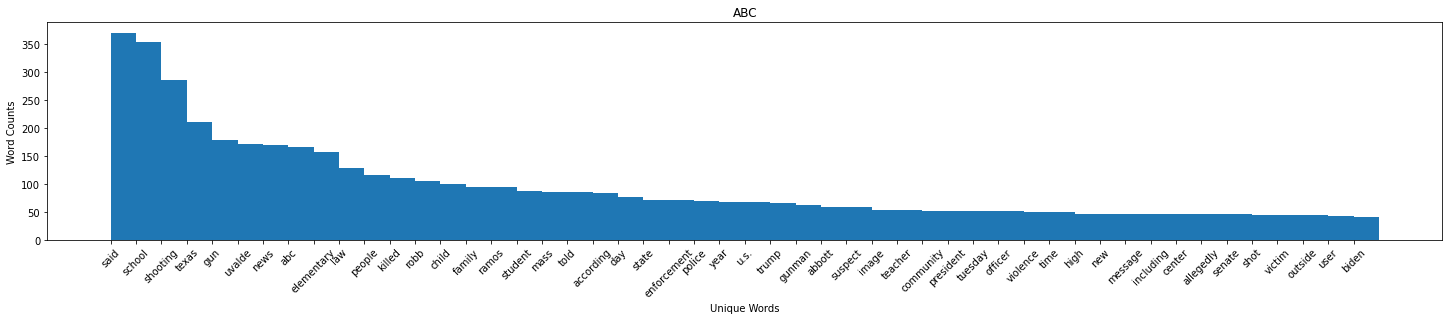

In [43]:
plotHist(abc_sentences, 'ABC')

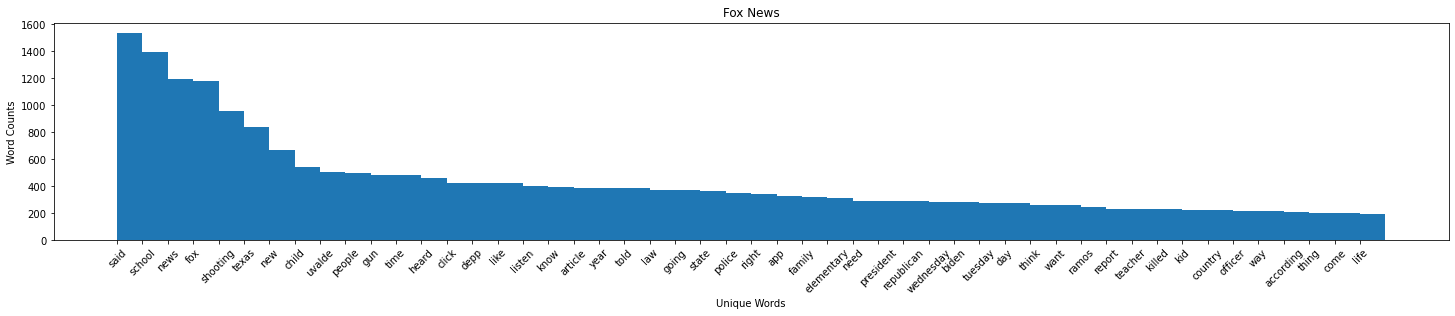

In [44]:
plotHist(fox_sentences, 'Fox News')

### 2. (10 pts) Construct the word clouds from the two texts.

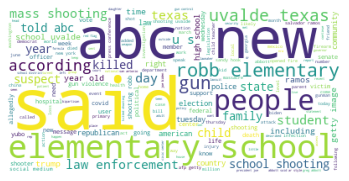

In [45]:
abc_words = []
for sent in abc_sentences:
    for word in sent:
        abc_words.append(word)

createWordcloud(' '.join(abc_words), 'abc_news.png')

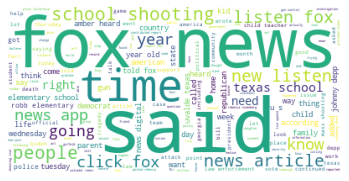

In [46]:
fox_words = []
for sent in fox_sentences:
    for word in sent:
        if (word != 'pm' and word != 'nt'):
            fox_words.append(word)

createWordcloud(' '.join(fox_words), 'fox_news.png')